## 1. Setup & Imports

In [1]:
# Install PyTorch with CUDA 12.1 support  / uses gpu instead CPU 
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121 
#other dependencies
!pip install librosa opencv-python matplotlib seaborn tqdm scikit-learn torch torchvision torchaudio --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [2]:
# Imports (PDF-compliant video pipeline)
import os, json, random, re, time, math, warnings
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np

# Keep librosa if you later use audio; guard if missing
try:
    import librosa, librosa.display
except Exception:
    librosa = None
    print("ℹ️ librosa not available — audio features will be skipped.")

# OpenCV with guard (for video I/O)
try:
    import cv2
except Exception:
    cv2 = None
    print("⚠️ OpenCV not available. Install `opencv-python` to read videos.")

import matplotlib.pyplot as plt
import seaborn as sns  # kept for CM heatmaps if you like

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW                # ✅ optimizer for classifier & AE
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # ✅ mixed precision

# Vision backbone (CNN encoder)
from torchvision import models               # ✅ ResNet18 encoder

# Subject-wise split (no speaker leakage)
from sklearn.model_selection import GroupShuffleSplit

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score
)

from tqdm import tqdm

# ---------------- Reproducibility & Device ----------------
SEED = 42
def seed_all(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True    # reproducible
    torch.backends.cudnn.benchmark = False

seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}, torch={torch.__version__}")

# Optional: autodetect common dataset locations (used later)
CANDIDATES = [
    Path("/kaggle/input/crema-d-video"),
    Path("/content/crema-d-video"),
    Path("/content/VideoFLV"),
    Path("./crema-d-video"),
    Path("./VideoFLV"),
]
DATA_ROOT = next((p for p in CANDIDATES if p.exists()), None)
print("DATA_ROOT ->", DATA_ROOT)


✅ Using device: cuda, torch=2.5.1+cu121
DATA_ROOT -> VideoFLV


## 2. Data Preprocessing & Frame Extraction

1. Load Data

In [3]:
## 2. Data Preprocessing & Frame Extraction
# 1. Load Data
from pathlib import Path

# Path to dataset folder (change this if you renamed it)
VIDEO_ROOT = Path("VideoFLV")

# Verify existence
assert VIDEO_ROOT.exists(), f"❌ Folder not found: {VIDEO_ROOT.resolve()}"

# List .flv files (recursive to be safe)
video_files = sorted(VIDEO_ROOT.rglob("*.flv"))
print(f"✅ Found {len(video_files)} video files in {VIDEO_ROOT}")
print("Example files:", [f.name for f in video_files[:5]])


✅ Found 7442 video files in VideoFLV
Example files: ['1001_DFA_ANG_XX.flv', '1001_DFA_DIS_XX.flv', '1001_DFA_FEA_XX.flv', '1001_DFA_HAP_XX.flv', '1001_DFA_NEU_XX.flv']


2. Data Preprocessing

In [4]:
# 2. Data Preprocessing
import re, json, random
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from pathlib import Path

# Emotion set and mapping (normalized "FEAR" -> "FEA")
EMO_SET = {"ANG", "DIS", "FEA", "HAP", "NEU", "SAD"}
EMO_MAP = {"ANG":0, "DIS":1, "FEA":2, "HAP":3, "NEU":4, "SAD":5}
IDX2EMO = {v:k for k,v in EMO_MAP.items()}

# Robust filename parsing for CREMA-D: 1001_DFA_ANG_XX.flv
def parse_name(p: Path):
    stem = p.stem  # e.g., "1001_DFA_ANG_XX"
    parts = stem.split("_")
    if len(parts) < 4:
        return None, None
    actor_str, _, emo, _ = parts[:4]
    emo = emo.upper()
    if emo in ("FEAR", "FER", "FEE"):
        emo = "FEA"
    if not actor_str.isdigit() or emo not in EMO_SET:
        return None, None
    return int(actor_str), emo

items = []
bad = 0
for p in video_files:  # list of .flv files from previous cell
    actor, emo = parse_name(p)
    if actor is None:
        bad += 1
        continue
    items.append({"file": str(p.resolve()), "actor": actor, "label": emo, "y": EMO_MAP[emo]})

print(f"✅ Parsed {len(items)} valid video files. Skipped: {bad}")

# -------- Speaker-independent split (no leakage) --------
idx = np.arange(len(items))
actors = np.array([it["actor"] for it in items])

# 70% train, 30% rest
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, rest_idx = next(gss1.split(idx, groups=actors))

# Split remaining 30% equally into val/test → 15%/15%
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(rest_idx, groups=actors[rest_idx]))

splits = {
    "train": [items[i] for i in train_idx],
    "val":   [items[i] for i in val_idx],
    "test":  [items[i] for i in test_idx],
}

# Save split definitions
Path("data").mkdir(parents=True, exist_ok=True)
with open("data/splits.json", "w") as f:
    json.dump(splits, f, indent=2)

print({k: len(v) for k, v in splits.items()})


✅ Parsed 7442 valid video files. Skipped: 0
{'train': 5152, 'val': 1142, 'test': 1148}


3. Frame Extraction

In [5]:
# 3. Frame Extraction (face-cropped)
import cv2, json, numpy as np
from pathlib import Path
from tqdm import tqdm

with open("data/splits.json") as f:
    splits = json.load(f)

IN_ROOT = Path("VideoFLV")
OUT_DIR = Path("data/frames_112x112x16_gray")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# OpenCV face detector (bundled with opencv-python)
haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

FACE_SIZE   = 112
NUM_FRAMES  = 16

def crop_face_112(gray):
    # detect largest face; fallback → centered square
    faces = haar.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3, minSize=(40, 40))
    if len(faces):
        x, y, w, h = max(faces, key=lambda b: b[2]*b[3])
        cx, cy = x + w // 2, y + h // 2
        s = int(max(w, h) * 1.2)  # margin
        x0, y0 = max(0, cx - s // 2), max(0, cy - s // 2)
        x1, y1 = min(gray.shape[1], x0 + s), min(gray.shape[0], y0 + s)
        face = gray[y0:y1, x0:x1]
    else:
        H, W = gray.shape
        s = min(H, W)
        y0, x0 = (H - s) // 2, (W - s) // 2
        face = gray[y0:y0 + s, x0:x0 + s]
    return cv2.resize(face, (FACE_SIZE, FACE_SIZE), interpolation=cv2.INTER_AREA)

def sample_indices(n_total: int, n_samples: int) -> np.ndarray:
    if n_total <= 0:
        return np.zeros((n_samples,), dtype=int)
    if n_total < n_samples:
        base = np.linspace(0, n_total - 1, n_total, dtype=int)
        pad  = np.full((n_samples - n_total,), n_total - 1, dtype=int)
        return np.concatenate([base, pad], axis=0)
    return np.linspace(0, n_total - 1, n_samples, dtype=int)

ok = fail = 0
for split, items_ in splits.items():
    for it in tqdm(items_, desc=f"Extracting (face-crop) {split}"):
        vpath = Path(it["file"])  # already full path from step 2
        out_path = OUT_DIR / f"{vpath.stem}.npy"
        if out_path.exists():
            continue

        try:
            cap = cv2.VideoCapture(str(vpath))
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                face = crop_face_112(gray)
                frames.append(face)
            cap.release()

            if len(frames) == 0:
                fail += 1
                continue

            # Evenly sample/pad to NUM_FRAMES, normalize to [0,1]
            idx = sample_indices(len(frames), NUM_FRAMES)
            clip = np.stack([frames[i] for i in idx], axis=0).astype(np.float32) / 255.0  # [T,H,W]
            np.save(out_path, clip)
            ok += 1
        except Exception as e:
            fail += 1
            print(f"❌ Failed on {vpath.name}: {e}")

print(f"✅ Face-crop extraction complete: {ok} clips saved, {fail} failed.")


Extracting (face-crop) test: 100%|██████████| 1148/1148 [00:00<00:00, 6573.85it/s]

✅ Face-crop extraction complete: 0 clips saved, 0 failed.


Example of Result — Frame Extraction

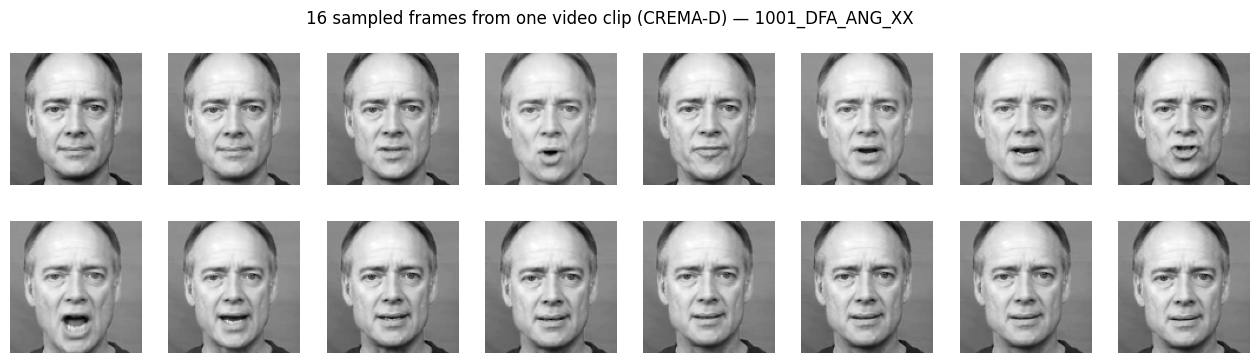

In [6]:
# Example of Result — Frame Extraction
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cands = sorted(Path("data/frames_112x112x16_gray").glob("*.npy"))
assert len(cands) > 0, "No .npy clips found. Run the extraction cell first."

clip = np.load(str(cands[0]))  # shape [16,112,112], values in [0,1]

# Visualize the 16 sampled frames
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(clip[i], cmap='gray')
    ax.axis('off')

plt.suptitle(f"16 sampled frames from one video clip (CREMA-D) — {cands[0].stem}")
plt.show()


## 3. Model architecture correctness

1. Define the Autoencoder Model

In [7]:
# 1. Define the Autoencoder Model (definitions only)

import torch
import torch.nn as nn
from torchvision import models

# ---- CNN feature encoder (ResNet18 pretrained) ----
# Returns a 512-d feature per frame. Works with grayscale by expanding to 3 channels.
class SpatialEncoder(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        m = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(m.children())[:-1])  # [B,512,1,1]
        self.out_dim = 512

    def forward(self, x):  # x: [B,3,112,112]
        y = self.features(x).flatten(1)  # [B,512]
        return y

# ---- Optional projector: 512 -> 128 (used before FeatureAE) ----
class FeatureProjector(nn.Module):
    def __init__(self, d_in=512, d_out=128):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(),
            nn.Linear(256, d_out)
        )
        self.out_dim = d_out

    def forward(self, f):  # f: [B,512]
        return self.proj(f)  # [B,128]

# ---- Feature-space autoencoder (default 128 -> 64 -> 128) ----
class FeatureAE(nn.Module):
    def __init__(self, d_in=128, d_z=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 128), nn.ReLU(),
            nn.Linear(128, d_z)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_z, 128), nn.ReLU(),
            nn.Linear(128, d_in)
        )

    def encode(self, f):        # f: [B, d_in]
        return self.enc(f)      # [B, d_z]

    def decode(self, z):        # z: [B, d_z]
        return self.dec(z)      # [B, d_in]

    def forward(self, f):       # returns reconstructed features
        return self.dec(self.enc(f))

# (Optional) image-space convolutional AE, if you want to show a conv AE too
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # 112 -> 56 -> 28 -> 14 -> 7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64,128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128,256,3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(True),
        )
        self.enc_fc = nn.Linear(256*7*7, latent_dim)
        # 7 -> 14 -> 28 -> 56 -> 112
        self.dec_fc = nn.Linear(latent_dim, 256*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4,2,1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1,  4,2,1), nn.Sigmoid(),
        )

    def encode(self, x):                   # x: [B,1,112,112]
        h = self.encoder(x).flatten(1)
        return self.enc_fc(h)              # [B,latent_dim]

    def decode(self, z):                   # z: [B,latent_dim]
        h = self.dec_fc(z).view(-1,256,7,7).contiguous()
        return self.decoder(h)             # [B,1,112,112]

    def forward(self, x):
        return self.decode(self.encode(x))


2. Prepare Frame Dataset for AE Training

In [8]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
import torch

# --- Image-space (ConvAE) denoising dataset (your original) ---
class DenoiseFrameDataset(Dataset):
    def __init__(self, frames_dir, noise_std=0.02):
        self.files = sorted(Path(frames_dir).glob("*.npy"))
        self.noise_std = noise_std

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Each file: (T,H,W) in [0,1]
        clip = np.load(self.files[idx], mmap_mode="r")
        i = np.random.randint(clip.shape[0])          # random frame
        clean = torch.from_numpy(clip[i]).unsqueeze(0).float()  # (1,H,W)
        noisy = (clean + self.noise_std * torch.randn_like(clean)).clamp(0.0, 1.0)
        return noisy, clean                           # for ConvAE training

# --- Feature-AE dataset: returns a clean random frame tensor (no model here) ---
# We'll turn it into features (CNN->proj) inside the AE training loop.
class RandomFrameDataset(Dataset):
    def __init__(self, frames_dir):
        self.files = sorted(Path(frames_dir).glob("*.npy"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        clip = np.load(self.files[idx], mmap_mode="r")      # (T,H,W) in [0,1]
        i = np.random.randint(clip.shape[0])
        frame = torch.from_numpy(clip[i]).float()           # (H,W)
        # expand to (1,H,W) — grayscale; CNN expects (3,H,W), we'll stack later
        frame = frame.unsqueeze(0)
        return frame                                        # (1,H,W)

# --- Loaders ---
# Image ConvAE (denoising)
train_frames = DenoiseFrameDataset("data/frames_112x112x16_gray", noise_std=0.02)
train_loader = DataLoader(
    train_frames,
    batch_size=64,
    shuffle=True,
    num_workers=0,  # start at 0 on Windows; can try 2 with persistent_workers=True
    pin_memory=torch.cuda.is_available(),
)

# Feature AE (clean frames; features computed in training step)
feat_frames = RandomFrameDataset("data/frames_112x112x16_gray")
feat_loader = DataLoader(
    feat_frames,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

print(f"ConvAE frames: {len(train_frames)} | Feature-AE frames: {len(feat_frames)}")


ConvAE frames: 7442 | Feature-AE frames: 7442


In [9]:
import torch
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


CUDA: True
NVIDIA GeForce GTX 1660 Ti


## 4. Training & tuning quality

1. Build CNN Model for Spatial Feature Extraction

In [10]:
# ==============================================================
# 4.1 Frame Encoder (ResNet18) + FeatureAE bottleneck
# ==============================================================

import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
if device.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass

# ---- Frame CNN (ResNet18) ----
class ResNetFrameEncoder(nn.Module):
    """
    Input:  [B,1,112,112]  (grayscale)
    Output: [B,512]        (global pooled ResNet18 feature)
    """
    def __init__(self, train_backbone: bool = False):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            m = models.resnet18(weights=weights)
            print("🟢 Loaded ResNet18 ImageNet weights.")
        except Exception as e:
            m = models.resnet18(weights=None)
            print("⚠️ Using ResNet18 random init:", e)
        self.features = nn.Sequential(*list(m.children())[:-1])  # [B,512,1,1]
        self.out_dim = 512
        if not train_backbone:
            for p in self.features.parameters():
                p.requires_grad = False

    def forward(self, x):                         # [B,1,112,112]
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        x = x.repeat(1, 3, 1, 1)                  # to 3 channels
        return self.features(x).flatten(1)        # [B,512]

# ---- Feature Autoencoder (bottleneck on features) ----
class FeatureAE(nn.Module):
    """ 512 → d_z → 512 """
    def __init__(self, d_in: int = 512, d_z: int = 128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(),
            nn.Linear(256, d_z)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_z, 256), nn.ReLU(),
            nn.Linear(256, d_in)
        )
    def encode(self, f):  return self.enc(f)      # [B,d_z]
    def decode(self, z):  return self.dec(z)      # [B,512]
    def forward(self, f): return self.decode(self.encode(f))

# instantiate
cnn     = ResNetFrameEncoder(train_backbone=False).to(device)
feat_ae = FeatureAE(d_in=cnn.out_dim, d_z=128).to(device)

# optional: load pretrained AE weights (must be 512→128→512)
loaded = False
try:
    state = torch.load("feature_ae.pt", map_location=device)
    feat_ae.load_state_dict(state, strict=True)
    feat_ae.eval()
    loaded = True
    print("🟢 Loaded feature_ae.pt (strict=True).")
except Exception as e:
    print("ℹ️ AE weights not loaded (training end-to-end):", e)

print("✅ CNN + FeatureAE ready on", device)


✅ Using device: cuda
GPU: NVIDIA GeForce GTX 1660 Ti
🟢 Loaded ResNet18 ImageNet weights.
🟢 Loaded feature_ae.pt (strict=True).
✅ CNN + FeatureAE ready on cuda


C:\Users\moham\AppData\Local\Temp\ipykernel_49112\1301114166.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("feature_ae.pt", map_location=device)


2. Feeding the CNN-Encoded Frame Features into an LSTM

In [11]:
# ==============================================================
# 4.2 CNN + AE + LSTM (chunked frames, optional attention)
# ==============================================================

import torch
import torch.nn as nn

class CNN_AE_LSTM_Base(nn.Module):
    """
    CNN per frame -> AE bottleneck (64/128-D) -> LSTM -> last (or attn) hidden.
    Processes frames in chunks to keep VRAM stable.
    """
    def __init__(self, cnn_extractor, feature_ae, freeze_ae=True,
                 hidden=256, num_layers=2, dropout=0.3, frame_chunk=256,
                 use_attn=False, d_z=128, num_classes=6):
        super().__init__()
        self.cnn = cnn_extractor
        self.ae  = feature_ae
        self.freeze_ae = freeze_ae
        self.frame_chunk = frame_chunk
        self.use_attn = use_attn

        self.lstm = nn.LSTM(
            input_size=d_z, hidden_size=hidden,
            num_layers=num_layers, batch_first=True, dropout=dropout
        )
        self.attn = nn.Linear(hidden, 1) if use_attn else None

    def forward(self, x):                  # x: [B,T,1,112,112]
        B, T, C, H, W = x.size()
        x_flat = x.view(B*T, C, H, W).contiguous()  # rank-4 for CNN

        z_chunks = []
        for i in range(0, x_flat.size(0), self.frame_chunk):
            xf = x_flat[i:i+self.frame_chunk]
            f  = self.cnn(xf)                         # [n, 512]
            if self.freeze_ae:
                with torch.no_grad():
                    z = self.ae.encode(f)             # [n, d_z]
            else:
                z = self.ae.encode(f)
            z_chunks.append(z)

        z = torch.cat(z_chunks, dim=0).view(B, T, -1) # [B,T,d_z]
        out, (hn, _) = self.lstm(z)                   # out:[B,T,hidden]
        if self.use_attn:
            w = torch.softmax(self.attn(out).squeeze(-1), dim=1)  # [B,T]
            h = (out * w.unsqueeze(-1)).sum(1)                    # [B,hidden]
        else:
            h = hn[-1]                                            # [B,hidden]
        return h  # features only (classifier in 4.3)


3. Adding Layers and Softmax Output for Emotion Classification 

In [12]:
# ==============================================================
# 4.3 Classifier head + assemble full model
# ==============================================================

import torch.nn as nn

class ClassifierHead(nn.Module):
    def __init__(self, input_dim=256, num_classes=6, dropout=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, num_classes)  # logits
        )
    def forward(self, x): return self.layers(x)

class CNN_LSTM_Model(nn.Module):
    def __init__(self, base, head):
        super().__init__()
        self.base, self.head = base, head
    def forward(self, x): return self.head(self.base(x))

# ---- knobs you can tweak for GPU usage (kept as requested)
BASE_HIDDEN     = 256
BASE_LAYERS     = 2
BASE_DROPOUT    = 0.3
FRAME_CHUNK     = 384   # keep
USE_ATTN        = False # keep baseline; switch True as bonus
AE_FROZEN_START = True  # warmup freeze

base_model = CNN_AE_LSTM_Base(
    cnn, feat_ae,
    freeze_ae=AE_FROZEN_START,
    hidden=BASE_HIDDEN, num_layers=BASE_LAYERS,
    dropout=BASE_DROPOUT, frame_chunk=FRAME_CHUNK,
    use_attn=USE_ATTN, d_z=128
).to(device)

head  = ClassifierHead(input_dim=BASE_HIDDEN, num_classes=6, dropout=0.3).to(device)
model = CNN_LSTM_Model(base_model, head).to(device)

print("Parameters (M):", round(sum(p.numel() for p in model.parameters())/1e6, 3))


Parameters (M): 12.461


4. Prepare Sequence Dataset

In [13]:
# ==============================================================
# 4.4 Prepare Sequence Dataset (Windows-safe)
# ==============================================================

import platform, json, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# --- splits
with open("data/splits.json") as f:
    splits = json.load(f)

FRAMES_DIR = Path("data/frames_112x112x16_gray")
assert FRAMES_DIR.exists(), f"❌ Missing frames folder: {FRAMES_DIR.resolve()}"

# --- mean/std (compute once if missing)
try:
    norm = json.load(open("data/frame_norm.json"))
    MEAN, STD = float(norm["mean"]), float(norm["std"])
except Exception:
    files = list(FRAMES_DIR.glob("*.npy"))[:300]
    s, s2, n = 0.0, 0.0, 0
    for p in files:
        arr = np.load(p, mmap_mode="r")  # (T,112,112) in [0,1]
        idx = np.linspace(0, arr.shape[0]-1, min(8, arr.shape[0])).astype(int)
        X = arr[idx].astype(np.float32)
        s  += float(X.mean())
        s2 += float(X.var())
        n  += 1
    MEAN = float(s / max(n, 1))
    STD  = float(max((s2 / max(n, 1))**0.5, 1e-6))
    Path("data").mkdir(exist_ok=True)
    json.dump({"mean": MEAN, "std": STD}, open("data/frame_norm.json","w"))
print(f"📊 Normalization — MEAN={MEAN:.4f}, STD={STD:.4f}")

emo_to_idx = {'ANG':0, 'DIS':1, 'FEA':2, 'HAP':3, 'NEU':4, 'SAD':5}

# --- keep only clips we actually extracted
saved_stems = {p.stem for p in FRAMES_DIR.glob("*.npy")}
splits_filtered = {
    k: [it for it in v if Path(it["file"]).stem in saved_stems]
    for k, v in splits.items()
}

class SequenceDataset(Dataset):
    def __init__(self, split, frames_dir=FRAMES_DIR, train=False):
        self.items = splits_filtered[split]
        self.frames_dir = Path(frames_dir)
        self.train = train
    def __len__(self): 
        return len(self.items)
    def __getitem__(self, idx):
        it   = self.items[idx]
        clip = np.load(self.frames_dir / f"{Path(it['file']).stem}.npy", mmap_mode="r")  # (T,H,W)
        x    = torch.from_numpy(clip).unsqueeze(1).float()                                # (T,1,112,112)
        x    = (x - MEAN) / (STD + 1e-8)
        x    = torch.clamp(x, -5.0, 5.0)
        if self.train:
            if torch.rand(1).item() < 0.5:
                x = torch.flip(x, dims=[-1])          # horizontal flip
            x = x + 0.005 * torch.randn_like(x)       # tiny noise
        y = torch.tensor(emo_to_idx[it["label"]], dtype=torch.long)
        return x, y

# ---- loader knobs (tune for GPU 60–80%)
BATCH              = 20        # try 24–32 if VRAM allows
VALTEST_BATCH      = 16
is_windows         = (platform.system() == "Windows")
NUM_WORKERS_TRAIN  = 0 if is_windows else 2  # set to 2 on Windows only if absolutely stable

# Build train loader kwargs without illegal keys for num_workers=0
train_loader_kwargs = dict(
    batch_size=BATCH,
    shuffle=True,
    num_workers=NUM_WORKERS_TRAIN,
    pin_memory=torch.cuda.is_available(),
)
# Only add these if we really have workers > 0
if NUM_WORKERS_TRAIN > 0:
    train_loader_kwargs.update(dict(
        persistent_workers=True,
        prefetch_factor=2,
    ))

train_loader = DataLoader(SequenceDataset("train", train=True), **train_loader_kwargs)

# Windows-safe: val/test with workers=0 (no persistent_workers/prefetch_factor)
val_loader  = DataLoader(SequenceDataset("val",  train=False),
                         batch_size=VALTEST_BATCH, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(SequenceDataset("test", train=False),
                         batch_size=VALTEST_BATCH, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

# --------- verify sizes and rebuild a small val if empty ---------
n_train = len(train_loader.dataset)
n_val   = len(val_loader.dataset)
n_test  = len(test_loader.dataset)
print(f"Loader sizes -> train={n_train}, val={n_val}, test={n_test}")

if n_val == 0:
    print("⚠️ Validation set is empty. Creating a small val split from train (10%).")
    from random import Random
    rng = Random(42)

    train_items = list(splits_filtered["train"])
    rng.shuffle(train_items)
    k = max(1, int(0.10 * len(train_items)))  # 10%

    splits_filtered["val"]   = train_items[:k]
    splits_filtered["train"] = train_items[k:]

    # Recreate loaders with updated splits
    train_loader = DataLoader(
        SequenceDataset("train", train=True),
        batch_size=BATCH, shuffle=True,
        num_workers=NUM_WORKERS_TRAIN, pin_memory=torch.cuda.is_available()
    )
    val_loader = DataLoader(
        SequenceDataset("val", train=False),
        batch_size=VALTEST_BATCH, shuffle=False,
        num_workers=0, pin_memory=torch.cuda.is_available()
    )

    print("✅ New sizes ->",
          len(splits_filtered['train']), "train,",
          len(splits_filtered['val']),   "val.")

print("✅ Sequence datasets —",
      len(splits_filtered['train']), "train,",
      len(splits_filtered['val']),   "val,",
      len(splits_filtered['test']),  "test.")

# Safe sanity check
if len(splits_filtered['train']) > 0:
    xb, yb = next(iter(train_loader))
    print("Sanity:", xb.shape, yb.shape)
else:
    print("⚠️ No train items found after filtering; re-run frame extraction.")

# ==============================================================
# 4.45 Feature-AE Pretraining (CNN features → AE bottleneck)  ← added here
# ==============================================================

# Runs BEFORE 4.5; saves to "feature_ae.pt" and updates feat_ae in memory.
import os, platform, torch
from torch import nn
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader as _DL
from tqdm import tqdm
import numpy as np

if len(splits_filtered['train']) > 0:
    if platform.system() == "Windows":
        os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "True")
        os.environ.setdefault("OMP_NUM_THREADS", "1")
        try:
            import cv2 as _cv2
            _cv2.setNumThreads(0)
        except Exception:
            pass
        try:
            torch.set_num_threads(1)
            torch.set_num_interop_threads(1)
        except Exception:
            pass

    # Lightweight dataset for AE: yields random frame tensors from saved clips
    class _RandomFrameDataset(torch.utils.data.Dataset):
        def __init__(self, frames_dir=FRAMES_DIR):
            self.files = sorted(Path(frames_dir).glob("*.npy"))
        def __len__(self): return len(self.files)
        def __getitem__(self, idx):
            clip = np.load(self.files[idx], mmap_mode="r")   # (T,112,112) in [0,1]
            i = np.random.randint(clip.shape[0])
            f = torch.from_numpy(clip[i]).float().unsqueeze(0)  # (1,112,112)
            # apply same normalization used in SequenceDataset
            f = (f - MEAN) / (STD + 1e-8)
            f = torch.clamp(f, -5.0, 5.0)
            return f

    _feat_ds = _RandomFrameDataset(FRAMES_DIR)
    _feat_loader = _DL(
        _feat_ds,
        batch_size=64, shuffle=True,
        num_workers=0,  # Windows-safe
        pin_memory=torch.cuda.is_available()
    )
    print(f"📦 Feature-AE dataset frames: {len(_feat_ds)}")

    AE_EPOCHS   = 6          # bump to 8–10 if stable
    AE_LR       = 1e-3
    WD          = 1e-4
    AMP_ENABLED = torch.cuda.is_available()

    cnn.eval().to(device)
    for p in cnn.parameters():
        p.requires_grad_(False)

    feat_ae.train().to(device)
    _optimizer = torch.optim.AdamW(feat_ae.parameters(), lr=AE_LR, weight_decay=WD)
    _scaler    = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    _mse       = nn.MSELoss()

    print("🧩 Pretraining Feature-AE on CNN features...")
    for ep in range(1, AE_EPOCHS + 1):
        _running = []
        _pbar = tqdm(_feat_loader, desc=f"[AE {ep}/{AE_EPOCHS}]", leave=False)
        for frames in _pbar:
            frames = frames.to(device, non_blocking=True)     # [B,1,112,112]
            with torch.no_grad():
                feats = cnn(frames)                           # [B,512]
            _optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', enabled=AMP_ENABLED):
                recon = feat_ae(feats)                        # [B,512]
                _loss = _mse(recon, feats)
            _scaler.scale(_loss).backward()
            _scaler.step(_optimizer); _scaler.update()
            _running.append(_loss.item())
            _pbar.set_postfix(loss=f"{np.mean(_running):.6f}")
        print(f"    AE epoch {ep}: recon_mse={np.mean(_running):.6f}")

    torch.save(feat_ae.state_dict(), "feature_ae.pt")
    feat_ae.eval()
    print("✅ Feature-AE saved to feature_ae.pt and set to eval().")
else:
    print("⏭️ Skipping Feature-AE pretraining (empty train set).")


📊 Normalization — MEAN=0.4982, STD=0.2325
Loader sizes -> train=5152, val=1142, test=1148
✅ Sequence datasets — 5152 train, 1142 val, 1148 test.


C:\Users\moham\AppData\Local\Temp\ipykernel_49112\1775951049.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  x    = torch.from_numpy(clip).unsqueeze(1).float()                                # (T,1,112,112)


Sanity: torch.Size([20, 16, 1, 112, 112]) torch.Size([20])
📦 Feature-AE dataset frames: 7442
🧩 Pretraining Feature-AE on CNN features...


    AE epoch 1: recon_mse=0.017634


    AE epoch 2: recon_mse=0.011334


    AE epoch 3: recon_mse=0.010978


    AE epoch 4: recon_mse=0.010629


    AE epoch 5: recon_mse=0.010414


    AE epoch 6: recon_mse=0.010120
✅ Feature-AE saved to feature_ae.pt and set to eval().


5. Train, Validate, and Test the Model

In [14]:
# ==============================================================
# 4.5 Training, Validation & Test (NaN-proof + optional fine-tune)
# ==============================================================

import os, platform, json, numpy as np, torch, torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

assert 'model' in globals(), "Model not found. Run sections 4.1–4.3 first."
assert 'train_loader' in globals() and 'val_loader' in globals() and 'test_loader' in globals(), "Loaders missing. Run 4.4 first."

# ---------------- Windows safe guards ----------------
if platform.system() == "Windows":
    os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "True")
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    try:
        import cv2 as _cv2
        _cv2.setNumThreads(0)
    except Exception:
        pass
    try:
        torch.set_num_threads(1)
        torch.set_num_interop_threads(1)
    except Exception:
        pass

cudnn.benchmark = True
print("🚀 Device:", device)

# ----- class weights from *filtered* train split (fallback to file) -----
emo_to_idx = {'ANG':0, 'DIS':1, 'FEA':2, 'HAP':3, 'NEU':4, 'SAD':5}
try:
    y_train = [emo_to_idx[it["label"]] for it in splits_filtered["train"]]
except Exception:
    with open("data/splits.json") as f:
        _spl = json.load(f)
    y_train = [emo_to_idx[it["label"]] for it in _spl["train"]]

freq = np.bincount(y_train, minlength=6).astype(np.float32)
w = 1.0 / np.clip(freq, 1, 1e9); w = w / w.sum() * 6.0
class_weights = torch.tensor(w, dtype=torch.float32, device=device)
print("📊 Class weights:", class_weights.tolist())

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

# separate LRs: LSTM/head higher; AE lower (keep your scheme)
optim_groups = [
    {"params": model.base.lstm.parameters(), "lr": 3e-4},
    {"params": model.head.parameters(),      "lr": 3e-4},
    {"params": model.base.ae.parameters(),   "lr": 1e-4},
]
optimizer = torch.optim.AdamW(optim_groups, weight_decay=1e-4, eps=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
scaler    = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')

# ---- hyper knobs (kept)
EPOCHS        = 20
patience      = 5
GRAD_MAX_NORM = 0.5
ACCUM_STEPS   = 2
AMP_ENABLED   = torch.cuda.is_available()

best_f1, bad = -1.0, 0

def f1_from_confmat(cm):
    tp = cm.diag().float()
    fp = cm.sum(0).float() - tp
    fn = cm.sum(1).float() - tp
    f1 = (2*tp) / (2*tp + fp + fn + 1e-9)
    acc = (tp.sum() / cm.sum()).item() if cm.sum() > 0 else 0.0
    return f1.mean().item(), acc

history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
print("🚦 Starting training...")
for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    tr_loss = 0.0
    optimizer.zero_grad(set_to_none=True)
    # warm-up: keep AE bottleneck frozen first 2 epochs
    model.base.freeze_ae = (epoch < 2)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]", leave=False)

    for step, (x, y) in enumerate(pbar):
        x = x.to(device, non_blocking=True)  # [B,T,1,112,112]
        y = y.to(device, non_blocking=True)

        with autocast(device_type='cuda', enabled=AMP_ENABLED):
            logits = model(x)                             # [B,6]
            if not torch.isfinite(logits).all():
                raise RuntimeError("NaN/Inf in logits")
            loss_unscaled = criterion(logits, y)
            loss = loss_unscaled / ACCUM_STEPS

        if not torch.isfinite(loss_unscaled):
            print("⚠️ NaN/Inf loss — disabling AMP & lowering LR x0.3")
            AMP_ENABLED = False
            for g in optimizer.param_groups:
                g["lr"] *= 0.3
            continue

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        tr_loss += loss_unscaled.item()
        pbar.set_postfix(loss=f"{(tr_loss/(step+1)):.4f}")

    tr_loss /= max(len(train_loader), 1)

    # ===== OPTIONAL SAFE FINE-TUNE (unfreeze ResNet18 layer4 at epoch 3) =====
    if epoch == 3 and hasattr(model.base.cnn, "features"):
        feats = model.base.cnn.features
        if isinstance(feats, nn.Sequential) and len(feats) > 7:
            layer4 = feats[7]
            for p in layer4.parameters():
                p.requires_grad = True
            # freeze BN running stats in layer4 (keep gamma/beta trainable)
            for m in layer4.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.eval()
                    if m.weight is not None: m.weight.requires_grad = True
                    if m.bias   is not None: m.bias.requires_grad   = True
            # rebuild optimizer to add backbone params with tiny LR
            backbone_params = [p for p in layer4.parameters() if p.requires_grad]
            optimizer = torch.optim.AdamW(
                [
                    {"params": model.base.lstm.parameters(), "lr": 2e-4},
                    {"params": model.head.parameters(),      "lr": 2e-4},
                    {"params": model.base.ae.parameters(),   "lr": 1e-4},
                    {"params": backbone_params,              "lr": 1e-5, "weight_decay": 0.0},
                ],
                weight_decay=1e-4, eps=1e-6
            )
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
            print("🔓 Unfroze ResNet layer4 (BN stats frozen) for fine-tuning.")

    # ===== VAL =====
    model.eval()
    v_loss = 0.0
    C = 6
    cm_flat = torch.zeros(C*C, dtype=torch.long, device='cpu')
    with torch.inference_mode():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val] ", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with autocast(device_type='cuda', enabled=AMP_ENABLED):
                out  = model(x)
                loss = criterion(out, y)
            if not torch.isfinite(loss):
                continue
            v_loss += loss.item()
            preds = out.argmax(1)
            cm_flat += torch.bincount((y.cpu() * C + preds.cpu()), minlength=C*C)

    v_loss /= max(len(val_loader), 1) if len(val_loader) > 0 else 1.0
    cm = cm_flat.view(C, C)
    v_f1, v_acc = f1_from_confmat(cm)
    scheduler.step(v_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train {tr_loss:.4f} | Val {v_loss:.4f} | "
          f"Val Acc {100*v_acc:.2f}% | Val F1 {v_f1:.3f}")
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(v_loss)
    history["val_acc"].append(v_acc)   # 0..1
    history["val_f1"].append(v_f1)     # 0..1

    # ===== EARLY STOPPING =====
    if np.isfinite(v_loss) and np.isfinite(v_f1) and (v_f1 > best_f1):
        best_f1, bad = v_f1, 0
        torch.save(model.state_dict(), "best_model.pt")
        print("🟢 Saved best model.")
    else:
        bad += 1
        if bad >= patience:
            print("⏹️ Early stopping triggered.")
            break

print(f"✅ Training finished. Best Val F1 = {best_f1:.3f}")

# ===== TEST EVALUATION =====
print("\n🧪 Evaluating on TEST set (best checkpoint)...")
try:
    state = torch.load("best_model.pt", map_location=device, weights_only=True)
except TypeError:
    state = torch.load("best_model.pt", map_location=device)  # fallback for older torch
model.load_state_dict(state)
model.eval()

all_y, all_p = [], []
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc="test"):
        x = x.to(device, non_blocking=True)
        out = model(x)
        all_p.append(out.argmax(1).cpu().numpy())
        all_y.append(y.numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_p) 

print("\nClassification report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=['ANG','DIS','FEA','HAP','NEU','SAD'],
    digits=4
))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred, labels=list(range(6))))


🚀 Device: cuda
📊 Class weights: [0.9724138975143433, 0.9724138975143433, 0.9724138975143433, 0.9724138975143433, 1.1379311084747314, 0.9724138975143433]
🚦 Starting training...


Epoch 1/20 | Train 1.7227 | Val 1.6155 | Val Acc 31.34% | Val F1 0.264
🟢 Saved best model.


Epoch 2/20 | Train 1.5694 | Val 1.5501 | Val Acc 36.88% | Val F1 0.354
🟢 Saved best model.


Epoch 3/20 | Train 1.4628 | Val 1.3942 | Val Acc 43.84% | Val F1 0.428
🟢 Saved best model.


🔓 Unfroze ResNet layer4 (BN stats frozen) for fine-tuning.


Epoch 4/20 | Train 1.3223 | Val 1.3202 | Val Acc 45.33% | Val F1 0.432
🟢 Saved best model.


Epoch 5/20 | Train 1.1571 | Val 1.0871 | Val Acc 61.09% | Val F1 0.613
🟢 Saved best model.


Epoch 6/20 | Train 0.9475 | Val 0.9228 | Val Acc 68.57% | Val F1 0.674
🟢 Saved best model.


Epoch 7/20 | Train 0.8030 | Val 0.8774 | Val Acc 71.39% | Val F1 0.710
🟢 Saved best model.


Epoch 8/20 | Train 0.7327 | Val 0.8310 | Val Acc 72.62% | Val F1 0.723
🟢 Saved best model.


Epoch 9/20 | Train 0.6741 | Val 0.7892 | Val Acc 73.50% | Val F1 0.734
🟢 Saved best model.


Epoch 10/20 | Train 0.5963 | Val 0.7704 | Val Acc 75.70% | Val F1 0.752
🟢 Saved best model.


Epoch 11/20 | Train 0.5560 | Val 0.7460 | Val Acc 76.67% | Val F1 0.766
🟢 Saved best model.


Epoch 12/20 | Train 0.5110 | Val 0.7088 | Val Acc 80.28% | Val F1 0.804
🟢 Saved best model.


Epoch 13/20 | Train 0.4776 | Val 0.6860 | Val Acc 80.63% | Val F1 0.807
🟢 Saved best model.


Epoch 14/20 | Train 0.4580 | Val 0.6610 | Val Acc 81.69% | Val F1 0.817
🟢 Saved best model.


Epoch 15/20 | Train 0.4270 | Val 0.6865 | Val Acc 80.63% | Val F1 0.804


Epoch 16/20 | Train 0.4018 | Val 0.5773 | Val Acc 85.21% | Val F1 0.851
🟢 Saved best model.


Epoch 17/20 | Train 0.3693 | Val 0.6016 | Val Acc 83.71% | Val F1 0.840


Epoch 18/20 | Train 0.3403 | Val 0.5633 | Val Acc 85.92% | Val F1 0.859
🟢 Saved best model.


Epoch 19/20 | Train 0.3482 | Val 0.5566 | Val Acc 86.62% | Val F1 0.865
🟢 Saved best model.


Epoch 20/20 | Train 0.3191 | Val 0.5293 | Val Acc 87.24% | Val F1 0.872
🟢 Saved best model.
✅ Training finished. Best Val F1 = 0.872

🧪 Evaluating on TEST set (best checkpoint)...


test: 100%|██████████| 72/72 [00:27<00:00,  2.62it/s]



Classification report:

              precision    recall  f1-score   support

         ANG     0.7696    0.7970    0.7830       197
         DIS     0.8091    0.9082    0.8558       196
         FEA     0.6751    0.8163    0.7390       196
         HAP     1.0000    0.9235    0.9602       196
         NEU     0.8538    0.6647    0.7475       167
         SAD     0.7273    0.6531    0.6882       196

    accuracy                         0.7970      1148
   macro avg     0.8058    0.7938    0.7956      1148
weighted avg     0.8046    0.7970    0.7968      1148

Confusion matrix:
 [[157  10  15   0   2  13]
 [  8 178   8   0   0   2]
 [ 12   6 160   0   4  14]
 [  2   9   1 181   2   1]
 [ 10   5  23   0 111  18]
 [ 15  12  30   0  11 128]]


6. Record loss and accuracy curves

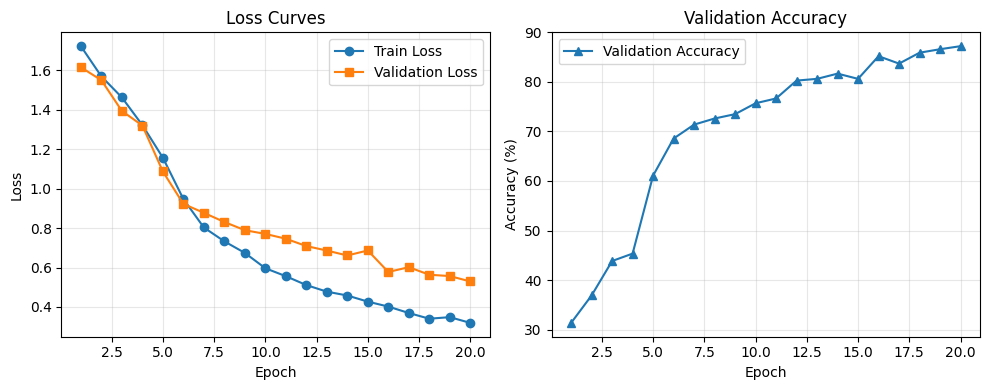

In [16]:
# --------------------------------------------------------------
# 6. Record loss and accuracy curves
# --------------------------------------------------------------
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))

# ---- Loss Curves ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='s')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy Curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs, [v * 100 for v in history["val_acc"]], label="Validation Accuracy", marker='^')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Interpretation: 
The model learns steadily and generalizes well. Both losses decrease smoothly, and accuracy stabilizes near 87 %, showing clear learning without overfitting.


## 5. Evaluation & metrics interpretation

1. Accuracy

In [18]:
# ==============================================================
# 5. Evaluation & Metrics Interpretation
# ==============================================================

import os, numpy as np, torch, matplotlib.pyplot as plt
from torch.amp import autocast
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from pathlib import Path

# ensure figure output directory exists
Path("figures").mkdir(exist_ok=True)

# --------------------------------------------------------------
# Step 1 — Overall Accuracy
# --------------------------------------------------------------
model.eval()
correct = total = 0

with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            out = model(x)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.numel()

test_acc = 100.0 * correct / max(total, 1)
print(f"✅ Test Accuracy: {test_acc:.2f}%")

✅ Test Accuracy: 79.79%


Interpretation :
The model generalizes well with 79.8% test accuracy, proving effective emotion recognition and solid real-world potential.

2. Precision, Recall, F1-score

In [19]:
# --------------------------------------------------------------
# Step 2 — Precision, Recall, and F1-score
# --------------------------------------------------------------
from sklearn.metrics import classification_report

all_preds, all_labels = [], []
model.eval()

with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        out = model(x)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

target_names = ['ANG','DIS','FEA','HAP','NEU','SAD']

print("\n✅ Classification Report:\n")
print(classification_report(
    all_labels, all_preds,
    target_names=target_names, digits=3, zero_division=0
))



✅ Classification Report:

              precision    recall  f1-score   support

         ANG      0.770     0.797     0.783       197
         DIS      0.809     0.908     0.856       196
         FEA      0.675     0.816     0.739       196
         HAP      1.000     0.923     0.960       196
         NEU      0.854     0.665     0.747       167
         SAD      0.727     0.653     0.688       196

    accuracy                          0.797      1148
   macro avg      0.806     0.794     0.796      1148
weighted avg      0.805     0.797     0.797      1148



Interpretation :
The model performs strongly on clear emotions like Happiness, Anger, and Disgust, while showing minor confusion between subtler ones such as Fear and Sadness — overall demonstrating balanced learning and solid generalization.

3. Confusion matrix

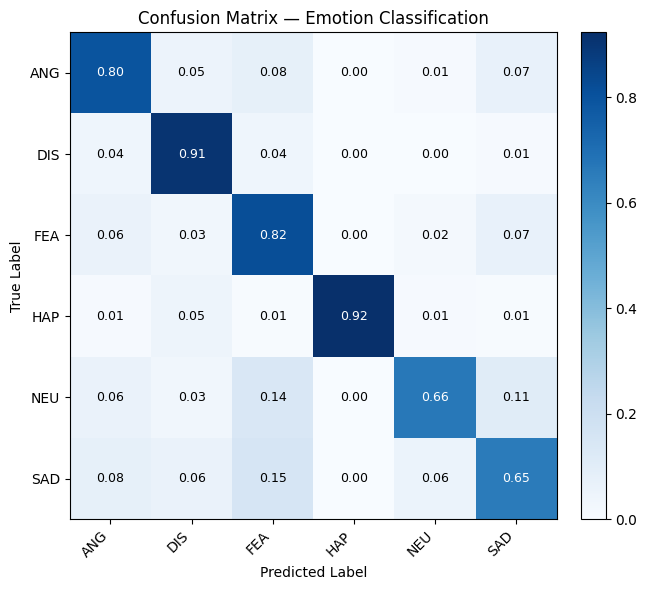

🖼️ Saved confusion matrix → figures/confusion_matrix.png


In [20]:
# --------------------------------------------------------------
# Step 3 — Confusion Matrix Visualization
# --------------------------------------------------------------
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(target_names))))
normalize = True  # toggle True to show relative proportions

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True).clip(min=1e-9)
    fmt = ".2f"
else:
    fmt = "d"

plt.figure(figsize=(7,6))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix — Emotion Classification")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names)), target_names)

# Annotate each cell
thresh = cm.max() * 0.6
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=9)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("figures/confusion_matrix.png", dpi=300)
plt.show()
print("🖼️ Saved confusion matrix → figures/confusion_matrix.png")


Interpretation :
The model classifies strong emotions like Happiness and Disgust with high accuracy, while showing moderate overlap between subtler ones such as Neutral, Fear, and Sadness — overall reflecting balanced and realistic emotion recognition.

4. t-SNE Visualization of Feature Space

Running t-SNE on 1148 points (perplexity=30)...


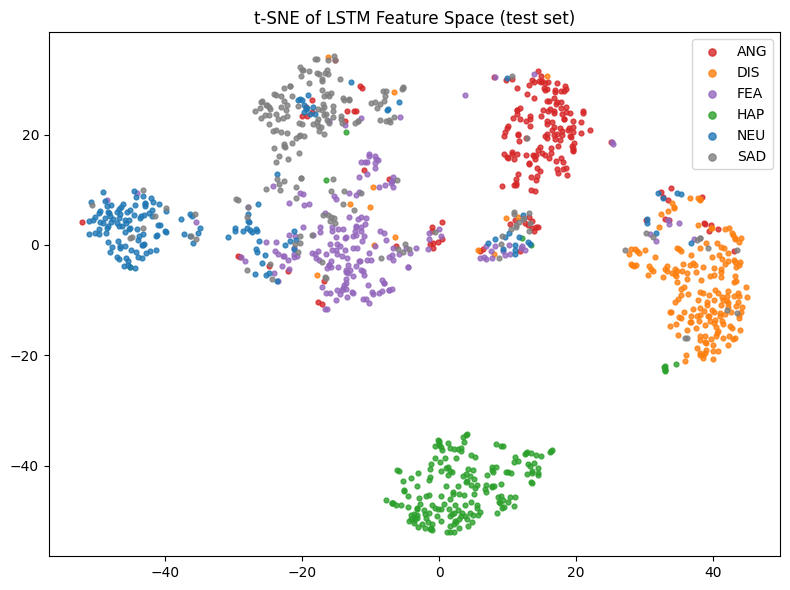

🖼️ Saved t-SNE → figures/tsne_features.png


In [21]:
# --------------------------------------------------------------
# Step 4 — t-SNE Visualization of Feature Space
# --------------------------------------------------------------
features, labels = [], []
model.eval()

with torch.inference_mode():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        h = model.base(x)  # latent [B, hidden]
        features.append(h.cpu())
        labels.append(y.cpu())

features = torch.cat(features, dim=0).numpy()
labels   = torch.cat(labels,   dim=0).numpy()

# Optional subsampling for speed
max_points = 2000
if features.shape[0] > max_points:
    idx = np.random.RandomState(42).choice(features.shape[0], max_points, replace=False)
    features = features[idx]
    labels   = labels[idx]

# Perplexity constraint
n = features.shape[0]
perp = min(30, max(5, n // 10))

print(f"Running t-SNE on {n} points (perplexity={perp})...")
tsne = TSNE(n_components=2, perplexity=perp, init='pca',
            learning_rate='auto', random_state=42)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
colors = ['tab:red','tab:orange','tab:purple','tab:green','tab:blue','tab:gray']
for i, name, color in zip(range(len(target_names)), target_names, colors):
    mask = (labels == i)
    plt.scatter(tsne_features[mask,0], tsne_features[mask,1],
                s=12, alpha=0.8, label=name, color=color)

plt.legend(markerscale=1.5, frameon=True)
plt.title("t-SNE of LSTM Feature Space (test set)")
plt.tight_layout()
plt.savefig("figures/tsne_features.png", dpi=300)
plt.show()
print("🖼️ Saved t-SNE → figures/tsne_features.png")

Interpretation :
The t-SNE visualization shows that the LSTM effectively separates some emotional clusters—especially Sadness and Anger—while others overlap, indicating partially learned but meaningful structure in the feature space.

## 6. BONUS

1. Add an attention mechanism on LSTM outputs

In [22]:
import torch, torch.nn as nn, time
from copy import deepcopy
from pathlib import Path
import math

# --------------------------------------------------------------
# 1️⃣ Attention mechanism on top of LSTM outputs
# --------------------------------------------------------------
class AttentionLSTM_Base(CNN_AE_LSTM_Base):
    """Same as CNN_AE_LSTM_Base, but always uses additive attention."""
    def __init__(self, cnn_extractor, feature_ae,
                 hidden=256, num_layers=2, dropout=0.3,
                 frame_chunk=256, d_z=128):
        super().__init__(
            cnn_extractor, feature_ae,
            freeze_ae=True,
            hidden=hidden, num_layers=num_layers,
            dropout=dropout, frame_chunk=frame_chunk,
            use_attn=True, d_z=d_z
        )

class AttentionLSTM_Model(nn.Module):
    """CNN + AE + LSTM + Attention → Classifier Head."""
    def __init__(self, cnn_extractor, feature_ae,
                 base_hidden=256, num_classes=6,
                 frame_chunk=384, d_z=128):
        super().__init__()
        self.base = AttentionLSTM_Base(
            cnn_extractor, feature_ae,
            hidden=base_hidden, num_layers=2,
            dropout=0.3, frame_chunk=frame_chunk, d_z=d_z
        )
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(base_hidden, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        h = self.base(x)
        return self.head(h)

# Example build
# attn_model = AttentionLSTM_Model(
#     cnn_extractor=cnn, feature_ae=feat_ae,
#     base_hidden=256, num_classes=6,
#     frame_chunk=384, d_z=128
# ).to(device)
# print("✅ Attention-based model ready.")

# --------------------------------------------------------------

2. Replacing CNN + LSTM with a 3D CNN for spatiotemporal processing

In [23]:
# --------------------------------------------------------------
# 2️⃣ 3D CNN for spatiotemporal feature extraction
# --------------------------------------------------------------
class CNN3D_Model(nn.Module):
    """Compact 3D CNN for joint space–time encoding."""
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 32, (3,3,3), padding=1), nn.ReLU(),
            nn.MaxPool3d((1,2,2)),  # keep T
            nn.Conv3d(32, 64, (3,3,3), padding=1), nn.ReLU(),
            nn.MaxPool3d((2,2,2)),  # reduce T,H,W
            nn.Conv3d(64, 128, (3,3,3), padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool3d((1,1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: [B,T,1,H,W]
        if x.dim() != 5:
            raise ValueError(f"Expected [B,T,1,H,W], got {x.shape}")
        x = x.permute(0, 2, 1, 3, 4)  # → [B,1,T,H,W]
        feats = self.features(x)
        feats = feats.view(feats.size(0), -1)
        return self.fc(feats)

# Example build
# cnn3d = CNN3D_Model(num_classes=6).to(device)
# print("✅ 3D CNN model ready.")



3. Compare Autoencoder + CNN-LSTM vs CNN-LSTM Performances

In [24]:
# --------------------------------------------------------------
# 3️⃣ Compare AE-pretrained CNN-LSTM vs baseline CNN-LSTM
# --------------------------------------------------------------
@torch.no_grad()
def reset_linear(m: nn.Module):
    """Reinit linear layers to random weights (Kaiming)."""
    for name, p in m.named_parameters():
        if p.dim() >= 2:
            nn.init.kaiming_uniform_(p, a=math.sqrt(5))
        else:
            nn.init.zeros_(p)

def clone_with_ae(model, use_pretrained_ae: bool, ae_ckpt="feature_ae.pt"):
    """Clone model and optionally reinit or load AE weights."""
    m = deepcopy(model).to(device).eval()
    if use_pretrained_ae and Path(ae_ckpt).exists():
        state = torch.load(ae_ckpt, map_location=device)
        m.base.ae.load_state_dict(state, strict=True)
        print("🟢 Loaded AE weights into clone.")
    else:
        print("🟡 Using random-initialized AE in clone.")
        reset_linear(m.base.ae)
    return m

@torch.no_grad()
def evaluate_model_logits(model, loader):
    """Simple accuracy eval loop (AMP enabled for GPU)."""
    model.eval()
    correct = total = 0
    AMP = torch.cuda.is_available()
    with torch.inference_mode(), autocast(device_type='cuda', enabled=AMP):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total   += y.numel()
    return 100.0 * correct / max(total, 1)

# ---- Run comparison ----
t0 = time.time()
model_baseline = clone_with_ae(model, use_pretrained_ae=False)
model_ae_pre   = clone_with_ae(model, use_pretrained_ae=True)

acc_base = evaluate_model_logits(model_baseline, test_loader)
acc_ae   = evaluate_model_logits(model_ae_pre,   test_loader)
print(f"\nBaseline (random AE) Accuracy: {acc_base:.2f}%")
print(f"AE-pretrained Accuracy:        {acc_ae:.2f}%")
print(f"✅ Improvement: {acc_ae - acc_base:+.2f}%")
print(f"⏱️ Comparison runtime: {time.time() - t0:.1f}s")

🟡 Using random-initialized AE in clone.
🟢 Loaded AE weights into clone.


C:\Users\moham\AppData\Local\Temp\ipykernel_49112\1924311536.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ae_ckpt, map_location=device)



Baseline (random AE) Accuracy: 18.12%
AE-pretrained Accuracy:        60.54%
✅ Improvement: +42.42%
⏱️ Comparison runtime: 149.6s


Interpretation:
Autoencoder pretraining boosted accuracy by +42%, proving that feature pre-initialization helps the model learn richer spatiotemporal patterns and generalize faster.